In [1]:
import numpy as np
from sklearn import model_selection
from cardiac_rythm import preprocessing


rng = np.random.RandomState(0)
# Load data and create dataframe
data_path = (
    "/home/halli/ux/BMDLab/matlab/resprog/GUI/CleanCutsDL/cutDataCinCTTI_rev_v2.mat"
)
df = preprocessing.load_data(data_path)


x = np.stack(df["s_ecg"].to_numpy())
x = x.reshape((*x.shape, 1))
y = df["c_label"].to_numpy()
y = y - 1  # 0-4 instead of 1-5

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x,
    y,
    test_size=0.1,
    random_state=rng,
    stratify=y,
)

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns


def get_metrics(y_test, prediction) -> None:
    conf_matrix = confusion_matrix(y_test, prediction)
    norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    bac = balanced_accuracy_score(y_test, prediction)

    # f, ax = plt.subplots(figsize=(4, 4))
    # sns.heatmap(norm, annot=True, linewidths=0.01, cmap="Oranges", linecolor="gray")
    # ax.xaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    # ax.yaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.title("Confusion Matrix")
    # plt.show()

    accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
    precision = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
    recall = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # print(f"{accuracy=}, {bac=}\n{precision=}\n{recall=}")
    return accuracy, bac

In [3]:
%%capture
from pathlib import Path
import keras

from cardiac_rythm.models import CNN, CNNConfig

def get_results(n_filters: int) -> tuple[list, CNN]:
    best_acc = 0
    best_bac = 0

    res_dir = Path(f"../../results/n_filters={n_filters}_n_fc=2/")
    # res_dir = Path(f"/var/home/halli/ux/bhome/heart_rythm_interpretation/results/n_filters={n_filters}_n_fc=2/")
    results = []
    acs = []
    bacs = []
    best_model = None
    for dir in res_dir.glob("trial_*"):
        try:
            with open(dir / "model_config.json", "r") as f:
                conf = CNNConfig.from_json(f.read())
                model = CNN(conf)
                model.load_weights(dir / "checkpoint").expect_partial()
                prediction = np.argmax(model.predict(x_test), axis=1)
                acc, bac = get_metrics(y_test, prediction)
                trainable_count = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
                results.append((acc, bac, trainable_count))
                if acc > best_acc:
                    print(f"Best acc: {acc}")
                    best_acc = acc
                    best_model = model
                if bac > best_bac:
                    print(f"Best bac: {bac}")
                    best_bac = bac
        except:
            pass
            # results.append((0, 0, 0))
    return results, best_model


2023-11-07 11:59:35.984498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 11:59:36.014352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 11:59:36.015084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 11:59:36.729281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%%capture
res_2, best_mod2 = get_results(2)
res_3, best_mod3 = get_results(3)
res_4, best_mod4 = get_results(4)
res_5, best_mod5 = get_results(5)

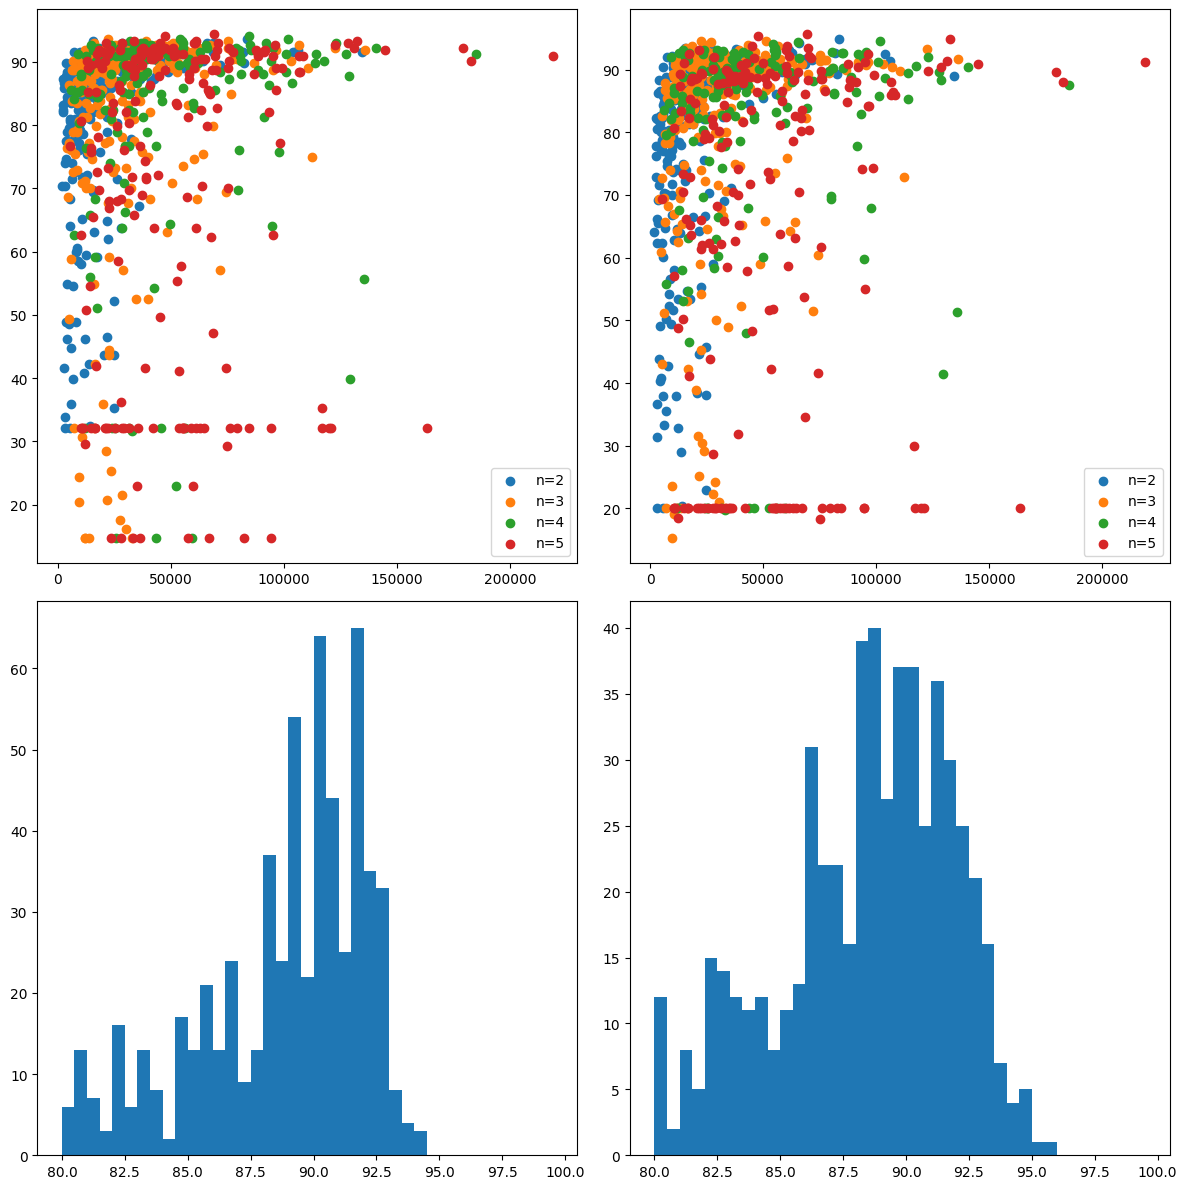

In [5]:
f, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()


def scatter_hist(ax, res, name) -> None:
    acs = []
    bacs = []
    n_params = []
    for acc, bac, n_param in res:
        acs.append(acc * 100)
        bacs.append(bac * 100)
        n_params.append(n_param)
    ax[0].scatter(n_params, acs, label=name)
    ax[1].scatter(n_params, bacs, label=name)
    ax[0].legend()
    ax[1].legend()
    bins = np.arange(80, 100, 0.5)
    # ax[2].hist(acs, bins, label=name)
    # ax[3].hist(bacs, bins, label=name)


acs = []
bacs = []
for res in [res_2, res_3, res_4, res_5]:
    for acc, bac, n_param in res:
        acs.append(acc * 100)
        bacs.append(bac * 100)
bins = np.arange(80, 100, 0.5)
ax[2].hist(acs, bins)
ax[3].hist(bacs, bins)
scatter_hist(ax, res_2, "n=2")
scatter_hist(ax, res_3, "n=3")
scatter_hist(ax, res_4, "n=4")
scatter_hist(ax, res_5, "n=5")
f.tight_layout()

9/9 [==============================] - 0s 5ms/step


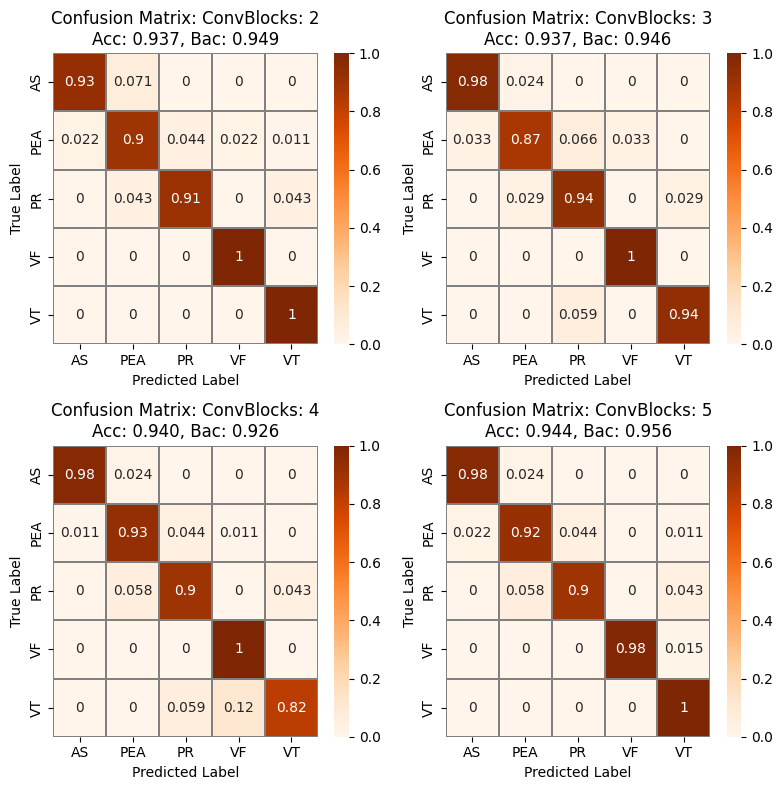

In [6]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
for i, model in enumerate([best_mod2, best_mod3, best_mod4, best_mod5]):
    prediction = np.argmax(model.predict(x_test), axis=1)
    conf_matrix = confusion_matrix(y_test, prediction)
    norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    bac = balanced_accuracy_score(y_test, prediction)
    acc = conf_matrix.diagonal().sum() / conf_matrix.sum()
    sns.heatmap(
        norm, annot=True, linewidths=0.01, cmap="Oranges", linecolor="gray", ax=ax[i]
    )
    ax[i].xaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    ax[i].yaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    ax[i].set_xlabel("Predicted Label")
    ax[i].set_ylabel("True Label")
    ax[i].set_title(
        f"Confusion Matrix: ConvBlocks: {i+2}\nAcc: {acc:.3f}, Bac: {bac:.3f}"
    )
f.tight_layout()
plt.show()

In [7]:
from cardiac_rythm.models import CNN


for i, model in enumerate([best_mod2, best_mod3, best_mod4, best_mod5]):
    model: CNN = model
    print(f"Model: {model.config}")

Model: CNNConfig(filters=[30, 50], kernels=[20, 50], strides=[1, 1], pool=[2, 2], padding='valid', fc_end=[64, 64], dropout=0.6)
Model: CNNConfig(filters=[50, 10, 20], kernels=[10, 20, 40], strides=[1, 1, 1], pool=[2, 2, 2], padding='valid', fc_end=[64, 32], dropout=0.2)
Model: CNNConfig(filters=[20, 20, 50, 50], kernels=[30, 15, 20, 20], strides=[1, 1, 1, 1], pool=[2, 2, 2, 2], padding='valid', fc_end=[64, 64], dropout=0.1)
Model: CNNConfig(filters=[5, 25, 40, 40, 50], kernels=[40, 40, 10, 5, 20], strides=[1, 1, 1, 1, 1], pool=[2, 2, 2, 2, 2], padding='valid', fc_end=[64, 32], dropout=0.30000000000000004)


In [8]:
conf_matrix.diagonal().sum() / conf_matrix.sum()

0.9436619718309859

9/9 [==============================] - 0s 5ms/step


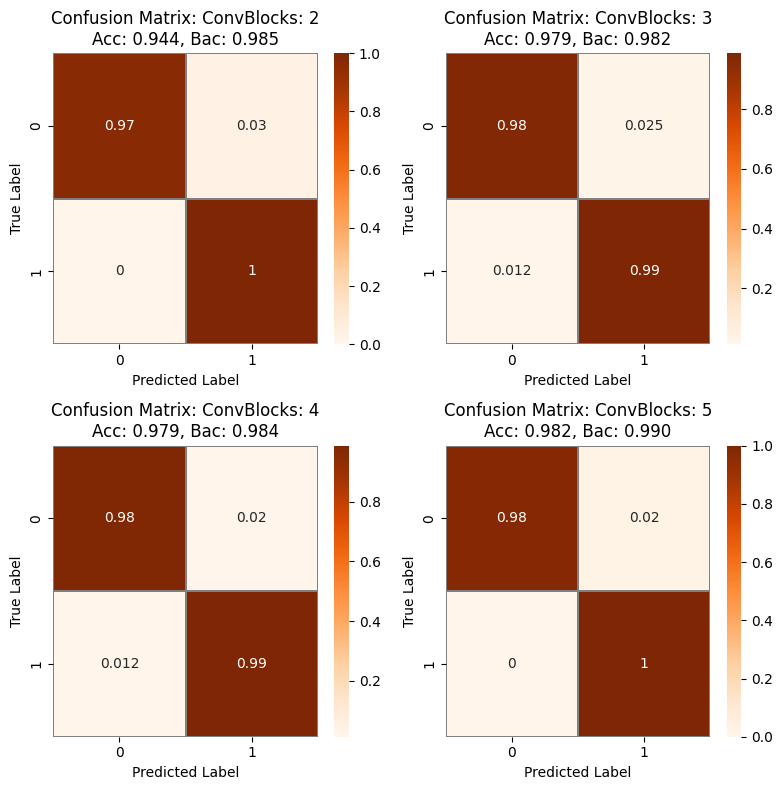

In [9]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
for i, model in enumerate([best_mod2, best_mod3, best_mod4, best_mod5]):
    prediction = np.argmax(model.predict(x_test), axis=1)
    prediction_shockable = np.where(prediction < 3, 0, 1)
    true_shockable = np.where(y_test < 3, 0, 1)

    conf_matrix = confusion_matrix(true_shockable, prediction_shockable)
    norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    bac = balanced_accuracy_score(true_shockable, prediction_shockable)
    sns.heatmap(
        norm, annot=True, linewidths=0.01, cmap="Oranges", linecolor="gray", ax=ax[i]
    )
    ax[i].set_xlabel("Predicted Label")
    ax[i].set_ylabel("True Label")
    ax[i].set_title(
        f"Confusion Matrix: ConvBlocks: {i+2}\nAcc: {acc:.3f}, Bac: {bac:.3f}"
    )
    acc = conf_matrix.diagonal().sum() / conf_matrix.sum()
f.tight_layout()
plt.show()

In [3]:
from cardiac_rythm.models import CNN, CNNConfig
from pathlib import Path
from IPython.display import clear_output
import pandas as pd


def get_df(n: int):
    n_filters = n
    res_dir = Path(f"../../results/n_filters={n_filters}_n_fc=2/")
    cnn_confs: list[CNNConfig] = []
    accs = []
    bacs = []
    for dir in res_dir.glob("trial_*"):
        try:
            with open(dir / "model_config.json", "r") as f:
                try:
                    conf = CNNConfig.from_json(f.read())
                    model = CNN(conf)
                    model.load_weights(dir / "checkpoint").expect_partial()
                except:
                    print(f"Failed to load model: {dir}")
                    continue
                prediction = np.argmax(model.predict(x_test), axis=1)
                acc, bac = get_metrics(y_test, prediction)
                cnn_confs.append(conf)
                accs.append(acc)
                bacs.append(bac)
                clear_output(wait=True)
        except:
            print(f"Error opening model config: {dir}")

    df = pd.DataFrame(cnn_confs)
    for i in range(n):
        df[f"K{i}"] = [x[i] for x in df["kernels"]]
        df[f"F{i}"] = [x[i] for x in df["filters"]]
    for i in range(2):
        df[f"FC{i}"] = [x[i] for x in df["fc_end"]]
    df["accs"] = accs
    df["bacs"] = bacs
    return df

2023-11-07 13:53:08.661779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 13:53:08.796557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 13:53:08.797247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 13:53:09.950253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import os


def box_n(n, y: str, name: str) -> None:
    f, ax = plt.subplots()
    for i in range(n):
        try:
            ax = sns.boxplot(
                data=df,
                x=df["accs"].round(2),
                y=f"{y}{i}",
                width=0.1,
                whis=[0, 100],
                orient="v",
                native_scale=True,
                ax=ax,
            )
            max_acc = df["accs"].round(2).max()
            ax.set_xlim([max_acc - 0.105, max_acc + 0.005])
            ax.set_xlabel("acc")
            os.makedirs("../../results/imgs/", exist_ok=True)

        # plt.savefig(f"../../results/imgs/{n}_{name}_{i}.svg", )
        except:
            pass
    plt.show()

In [93]:
# df_2 = get_df(2)
# df_3 = get_df(3)
# df_4 = get_df(4)
df_5 = get_df(5)
# box_n(n, "K", "kernel")
# box_n(n, "F", "filters")
# box_n(n, "FC", "fully_connected")

9/9 [==============================] - 0s 5ms/step


In [103]:
n = 2
df_n = df_2

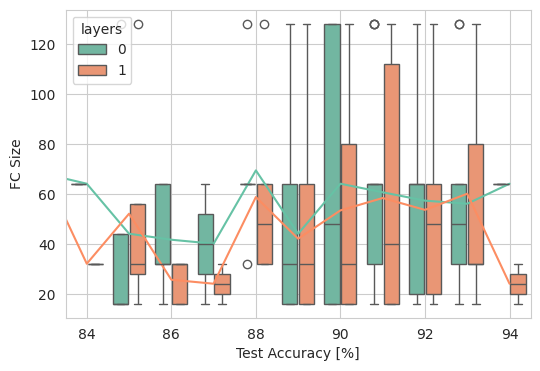

In [80]:
# val_type = "Kernel size"
# hue = "kernel"
# df_type = "K"

# val_type = "Filters"
# hue = "filter"
# df_type = "F"

# val_type = "FC Size"
# hue = "layers"
# df_type = "FC"


accs = (df_n["accs"].to_numpy() * 100).round(0)
v_0 = df_n[f"{df_type}0"]
convblock = [0] * len(accs)
tdf = pd.DataFrame({val_type: v_0, hue: convblock, "accs": accs})
# for i in range(1, 2): # if fc
# for i in range(1, n): # else
#     v = df_n[f"{df_type}{i}"]
#     convblock = [i] * len(accs)
#     new_rows = pd.DataFrame({val_type: v, hue: convblock, "accs": accs})
#     tdf = pd.concat([tdf, new_rows], ignore_index=True)
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=tdf,
    x="accs",
    y=val_type,
    hue=hue,
    gap=0.1,
    orient="v",
    native_scale=True,
    palette="Set2",
    ax=ax,
)
sns.lineplot(
    data=tdf,
    x="accs",
    y=val_type,
    hue=hue,
    estimator=np.mean,
    err_style=None,
    palette="Set2",
    legend=None,
)
max_acc = tdf["accs"].max()
ax.set_xlim([max_acc - 10.5, max_acc + 0.5])
ax.set_xlabel("Test Accuracy [%]")
plt.savefig(f"../../results/imgs/{n}_{hue}.svg")

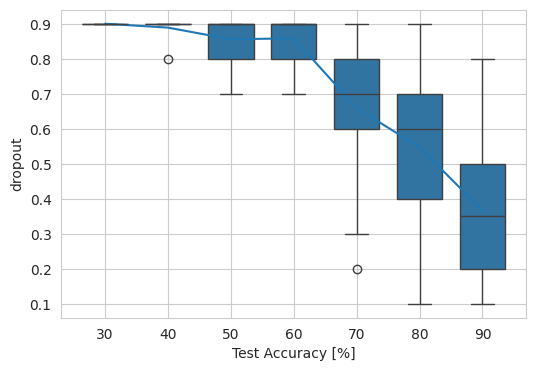

In [104]:
df_n["acc"] = (df_n["accs"] * 100).round(-1)
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=df_n,
    x="acc",
    y="dropout",
    gap=0.1,
    orient="v",
    native_scale=True,
    ax=ax,
)
sns.lineplot(
    data=df_n,
    x="acc",
    y="dropout",
    estimator=np.mean,
    err_style=None,
    legend=None,
)
max_acc = df_n["acc"].max()
# ax.set_xlim([max_acc - 10.5, max_acc + 0.5])
ax.set_xlabel("Test Accuracy [%]")
plt.savefig(f"../../results/imgs/{n}_dropout.svg")

In [1]:
from dataclasses import dataclass

from cardiac_rythm.hyper_tune import search_for_hyperparameters

import numpy as np
@dataclass
class OverrideArgs:
    file_path = "/var/home/halli/ux/BMDLab/matlab/resprog/GUI/CleanCutsDL/cutDataCinCTTI_rev_v2.mat"
    max_trials = 260
    n_folds = 10
    n_filters = 2
    filters = [5, 10, 15, 20, 25, 30, 40, 50]
    kernels = [5, 10, 15, 20, 25, 30, 40, 50]
    dropout = [0.1, 0.9]
    pool = [2]
    stride = [1]
    n_fc = 2
    fc_choice = [16, 32, 64, 128]
    override = True
args = OverrideArgs()
search_for_hyperparameters(args, np.random.RandomState(0))

2023-11-07 15:34:03.515046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 15:34:03.550798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 15:34:03.551865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 15:34:04.610923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


NameError: name 'np' is not defined